Training set size: 96
Test set size: 24
                                     SARIMAX Results                                      
Dep. Variable:                    export_restored   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1302.659
Date:                            Wed, 14 May 2025   AIC                           2615.318
Time:                                    02:01:30   BIC                           2627.412
Sample:                                01-01-2015   HQIC                          2620.177
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1160      0.201     -0.578      0.563      -0.509       0

c:\Users\kb010\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kb010\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


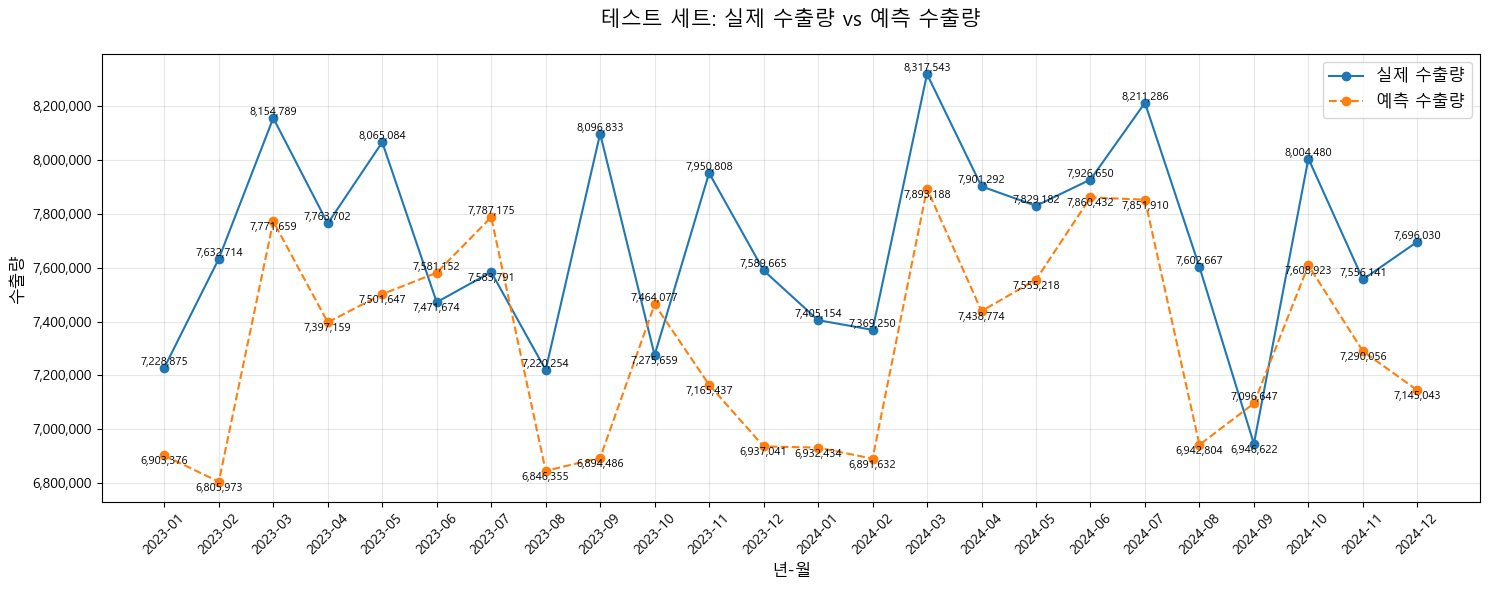


실제값과 예측값 비교:
             실제 수출량   예측 수출량
2023-01-01  7228875  6903376
2023-02-01  7632714  6805973
2023-03-01  8154789  7771659
2023-04-01  7763702  7397159
2023-05-01  8065084  7501647
2023-06-01  7471674  7581152
2023-07-01  7583791  7787175
2023-08-01  7220254  6846355
2023-09-01  8096833  6894486
2023-10-01  7275659  7464077
2023-11-01  7950808  7165437
2023-12-01  7589665  6937041
2024-01-01  7405154  6932434
2024-02-01  7369250  6891632
2024-03-01  8317543  7893188
2024-04-01  7901292  7438774
2024-05-01  7829182  7555218
2024-06-01  7926650  7860432
2024-07-01  8211286  7851910
2024-08-01  7602667  6942804
2024-09-01  6946622  7096647
2024-10-01  8004480  7608923
2024-11-01  7556141  7290056
2024-12-01  7696030  7145043


In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA도 SARIMAX로 구현
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ.csv')

# date 컬럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# 타겟 변수만 선택 (SARIMA는 외생 변수 사용 안 함)
target = df['export_restored']

# 학습/테스트 데이터 분할 (80:20)
train_size = int(len(df) * 0.8)
train_target = target[:train_size]
test_target = target[train_size:]

print('Training set size:', len(train_target)) # 학습 데이터 크기 96개월
print('Test set size:', len(test_target)) # 테스트 데이터 크기 24개월

# SARIMA 모델 학습 (모델은 SARIMAX를 사용하되 exog=None) << 외생 변수 사용이 안되기 때문문
# order=(p,d,q), seasonal_order=(P,D,Q,s)
model = SARIMAX(train_target,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))  # 계절성 유지

results = model.fit()
print(results.summary())

# 예측 수행
predictions = results.predict(start=len(train_target),
                            end=len(train_target) + len(test_target) - 1)

# 모델 성능 평가
mse = mean_squared_error(test_target, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_target, predictions)
r2 = r2_score(test_target, predictions)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R2 Score:', r2)

# ---------------------- 여기서부터는 시각화 코드 ----------------------------
# 실제값과 예측값 시각화
plt.figure(figsize=(15, 6))

# 실제값과 예측값을 포함하는 데이터프레임 생성
results_df = pd.DataFrame({
    '실제 수출량': test_target,
    '예측 수출량': predictions
})

# x축 눈금을 위한 날짜 리스트 생성
dates = results_df.index.strftime('%Y-%m')

# 그래프 그리기
plt.plot(range(len(dates)), results_df['실제 수출량'], 
         marker='o', linestyle='-', label='실제 수출량', color='#1f77b4')
plt.plot(range(len(dates)), results_df['예측 수출량'], 
         marker='o', linestyle='--', label='예측 수출량', color='#ff7f0e')

# 실제값과 예측값 텍스트 표시 (겹치지 않게 조정)
for i in range(len(dates)):
    real_val = results_df['실제 수출량'].iloc[i]
    pred_val = results_df['예측 수출량'].iloc[i]
    
    # 실제값이 예측값보다 큰 경우
    if real_val >= pred_val:
        # 실제값은 위에, 예측값은 아래에 표시
        plt.text(i, real_val, f'{real_val:,.0f}', 
                verticalalignment='bottom', 
                horizontalalignment='center',
                fontsize=8)
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                verticalalignment='top', 
                horizontalalignment='center',
                fontsize=8)
    else:
        # 예측값은 위에, 실제값은 아래에 표시
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                verticalalignment='bottom', 
                horizontalalignment='center',
                fontsize=8)
        plt.text(i, real_val, f'{real_val:,.0f}', 
                verticalalignment='top', 
                horizontalalignment='center',
                fontsize=8)

# 그래프 스타일링
plt.title('테스트 세트: 실제 수출량 vs 예측 수출량', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(range(len(dates)), dates, rotation=45)

# y축 값 포맷팅 (천 단위 구분기호)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 여백 조정
plt.tight_layout()
plt.show()

# 결과를 데이터프레임으로 출력
results_df = results_df.round(0).astype(int)
print("\n실제값과 예측값 비교:")
print(results_df.to_string(float_format=lambda x: '{:,.0f}'.format(x)))